# Alz specific gene analysis
A recent research on Alzheimer disease at 2019 identified 198 unique genes of interest from both table 1 and supplementary table 13. They are

34 genes from 
   >Table 1: Significantly associated regions identified in the GWAS of AD case-control status, AD-by-proxy phenotype, and meta-analysis

192 genes from 
   >Supplementary Table 13: Genes implicated by positional mapping, eQTL or chromatin interaction mapping of significant GWAS SNPs.

Among them, 6 genes in Table 1 are not covered in S_Table 13, making a total of 198 genes.

This analysis take these regions, cross reference them with the genes that were sequenced in the ROSMAP data set, and then compute the weight and Association stats for it. 


## Method
### Data wrangling and Region list extraction.
Before started,two csv format gene list was extracted from both table 1,via microsoft word OCR, and the downloaded supplemanty table 13 of the paper.

The code used for extractng a region list is shown below. 

The first section correct various mistake in Table 1 that can inhibit the annotation and matching process. Then ensemble ID are attched to table 1 based using "hsapiens_gene_ensembl" data base as table 13 already have ensemble ID comming with it. The checking of both gene name and ensemble ID ensure there is no duplication of genes. 

The genes are then used to compared with both the DLPFC and the PCC.  

162 out of 192 genes are included in the ROSMAP DLPFC gene expression files and 160 are in that of PCC, both are stored for follow up analysis. For the excluded genes, please see:https://github.com/cumc/neuro-twas/issues/20

    The following codes are meant to be ran in a R enviorment with package collection tidyverse installed.

In [4]:
library(dplyr)
library(readr)
library(tibble)
library(ggplot2)
library(stringr)
library("biomaRt")
table_13 = read_csv("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/table_13.csv",skip = 3)%>%janitor::clean_names()%>%dplyr::select(chr,gene,ensembl_id)
table_1 = read_csv("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/table_1.csv",skip = 2)%>%janitor::clean_names()%>%dplyr::select(chr,gene,snp)
table_13 = table_13[1:192,]
table_1[,3]=1
table_1 = table_1%>%na.omit()
# Manual change the error in table_1
#Typo in the paper
table_1$gene[table_1$gene == "INPPD5"] = "INPP5D"
#Alternative name for same genes
table_1$gene[table_1$gene == "AC074212.3"] = "BHMG1"
table_1$gene[table_1$gene == "BZRAP1-AS1"] = "TSPOAP1-AS1"
#Two genes putted together
table_1$gene[table_1$gene == "CLU/PTK2B"] = "CLU"
table_1 = rbind(table_1,c(8,"PTK2B",1))

table_1%>%filter(!gene%in%table_13$gene)

# Annotated the ID for table_1
ensembl = useDataset("hsapiens_gene_ensembl",mart=useMart("ENSEMBL_MART_ENSEMBL"))
ensembl_df <- getBM(attributes=c("ensembl_gene_id","chromosome_name", "start_position", "end_position","external_gene_name"),mart=ensembl)%>%filter(!str_detect(chromosome_name,"CHR"))
table_1_anno = left_join(x = table_1, y = ensembl_df, by = c("gene" = "external_gene_name"))%>%dplyr::select(gene,"ensembl_id" = ensembl_gene_id,chr)
table_1_anno[is.na(table_1_anno$ensembl_id),]

# Remove the * in table_13
str_detect(Name,"\\*")
table_13[str_detect(table_13$gene,"\\*"),] = table_13%>%filter(str_detect(gene,"\\*"))%>%mutate(gene = str_sub(gene,end=-2))


# combined the two table and remove the duplicated. table 1 bring 7 additional genes to table 13
Alz_gene = rbind(table_1_anno,table_13)%>%filter(!duplicated(gene))
Alz_gene

# Find if all the genes present in the ROSMAP dataset

#DLPFC
RSM_DLPFC_gene_list = readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/gene_exp/DLPFC/geneCountsResidualsPlusBaselineAgeGenderAdj_rename.txt","\t")
# A total of 162 genes are present in the DLPFC gene exp
Alz_gene_notIn_DLPFC = Alz_gene%>%filter(!ensembl_id%in%RSM_DLPFC_gene_list$gene_ID)

#PCC

readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/geneTpmResidualsAgeGenderAdj_rename_region_list.txt","\t")

RSM_PCC_gene_list = readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt","\t")
Alz_gene_notIn_PCC = Alz_gene%>%filter(!ensembl_id%in%RSM_PCC_gene_list$gene_ID)


Alz_gene_notIn_PCC[!Alz_gene_notIn_PCC$gene%in%Alz_gene_notIn_DLPFC$gene,]

#AC
RSM_AC_gene_list = readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/geneCountsResidualsAgeGenderAdj.txt"," ")
Alz_gene_notIn_AC = Alz_gene%>%filter(!ensembl_id%in%RSM_AC_gene_list$gene_ID)

# Gene that are only excluded from AC 
Alz_gene_notIn_AC[!Alz_gene_notIn_AC$gene%in%Alz_gene_notIn_PCC$gene,]

# Gene that are excluded from PCC and DLPFC only
Alz_gene_notIn_PCC[!Alz_gene_notIn_PCC$gene%in%Alz_gene_notIn_AC$gene,]

#See what gene from table 1 are excluded, both gene_set
table_1_anno[table_1_anno$ensembl_id%in%Alz_gene_notIn_PCC$ensembl_id,] 
table_1[table_1$gene%in%Alz_gene_notIn_AC$gene,]

#See what gene from table 13 are excluded
table_13[table_13$gene%in%Alz_gene_notIn_PCC$gene,]%>%filter(gene == "EXOC3L2")
table_13[table_13$gene%in%Alz_gene_notIn_AC$gene,]

#Check if the excluded gene have alternative ensemble ID in PCC and DLPFC, and if it was presented(No)
ensembl_df%>%filter(external_gene_name%in%Alz_gene_notIn_PCC$gene,!ensembl_gene_id%in%Alz_gene_notIn_PCC$ensembl_id)
RSM_DLPFC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)%>%filter(gene_ID == "ENSG00000283632")
RSM_PCC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)%>%filter(gene_ID == "ENSG00000283632")
#Check if the excluded gene have alternative ensemble ID in AC, and if it was presented(No)
ensembl_df%>%filter(external_gene_name%in%Alz_gene_notIn_AC$gene,!ensembl_gene_id%in%Alz_gene_notIn_AC$ensembl_id)
RSM_AC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)%>%filter(gene_ID == "ENSG00000283632")


# Export the region list for DLPFC and PCC, AC
RSM_ALZ_gene_DLPFC = RSM_DLPFC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)
RSM_ALZ_gene_DLPFC%>%write_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/DLPFC/RSM_Alz_region_list.txt",delim = "\t")

RSM_ALZ_gene_PCC = RSM_PCC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)
RSM_ALZ_gene_PCC%>%write_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/PCC/RSM_Alz_region_list.txt",delim = "\t")

RSM_ALZ_gene_AC = RSM_AC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)
RSM_ALZ_gene_AC%>%write_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/AC/RSM_Alz_region_list.txt",delim = "\t")



Parsed with column specification:
cols(
  .default = col_double(),
  Gene = col_character(),
  `Ensembl ID` = col_character(),
  `eqtlMap Tissues` = col_character(),
  `eqtlMap Direction` = col_character(),
  ciMap = col_character(),
  `ciMap Tissues` = col_character(),
  IndSigSNPs = col_character(),
  `TWAS P` = col_character(),
  `TWAS Tissue` = col_character(),
  `Additional TWAS Tissues` = col_character()
)

See spec(...) for full column specifications.

Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Duplicated column names deduplicated: 'SNP' => 'SNP_1' [7], 'P' => 'P_1' [8], 'SNP' => 'SNP_2' [9], 'P' => 'P_2' [15]”
Parsed with column specification:
cols(
  X1 = col_logical(),
  Locus = col_character(),
  Chr = col_double(),
  Gene = col_character(),
  SNP = col_character(),
  P = col_character(),
  SNP_1 = col_character(),
  P_1 = col_character(),
  SNP_2 = col_character(),
  bp = col_double(),
  A1 = col_character(),
  A2 = col_character(),
  MAF 

chr,gene,snp
<chr>,<chr>,<chr>
4,CLNK,1
4,HS3ST1,1
6,HLA-DRB1,1
10,ECHDC3,1
16,KAT8,1
17,ABI3,1
17,TSPOAP1-AS1,1
18,SUZ12P1,1
19,BHMG1,1


gene,ensembl_id,chr
<chr>,<chr>,<chr>


ERROR: Error in stri_detect_regex(string, pattern, negate = negate, opts_regex = opts(pattern)): 找不到对象'Name'


## Weight Computation and association testing
Since the region extracted and the sum stat are availble at the moments. The weight computation and association testing are performed on one go. A workflow are ran for both the DLPFC, PCC and AC for both all the SNVs in the WGS dataset(with a surfix: FULL) and also a selection of SNVs that have GWAS score with Alz disease reported. 

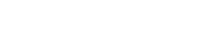



For the study, most parameters are ran using the standard twas_fusion workflow, with the following specifications for the weight computation steps:

    All five models are used.
    A window of 10000 bp beforee and after the gene was used.
   >Positional mapping maps SNPs to genes based on physical distance (within a 10-kb window) from known protein-coding genes in the human reference assembly (GRCh37/hg19).
    
    The cut off p.value of heritability is 0.01


In [ ]:
#DLPFC, Full 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_FULL_2 \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 10000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#DLPFC, SNP 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 6 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &





#PCC, Full
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_Full \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#PCC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &




#AC, FULL

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_FULL \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &



#AC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

## Hsq estimation and weight computation using susieR
To achieve more transparancy and preparing justification for multivariate analysis using Susie. SusieR is used to re-estimate the weights and the hsq of each tissue.

In [ ]:
#DLPFC, Full 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_FULL_2 \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml &

#DLPFC, SNP 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 6 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml &





#PCC, Full
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_Full \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &






#AC, FULL

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_FULL \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml &


ENSG00000159784
#AC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &


#PCC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml&

library(dplyr)
Chr7 = readr::read_delim("/mnt/mfs/ctcn/datasets/rosmap/wgs/ampad/variants/snvCombinedPlink/chr7.bim",delim = "\t")
colnames(Chr7)[4] = "Pos"
Chr7%>%filter(Pos>100562228,Pos<100596129)## Result

### Gene exclusion
At the second step of the workflow, two genes are excluded in the plink stages for DLPFC due to the reason of "All variants excluded". They are ENSG00000077454 and ENSG00000205307. A "All variants excluded" in plink stand for:

>The filtering flags you specified caused every last sample or every last variant to be excluded from the analysis.

Indeed there are no SNP in the chr7: 100562228 ~ 100596129 where ENSG00000205307 and ENSG00000077454 located.

As the ENSG00000205307 is not in the dataset of PCC, only one gene: ENSG00000077454 are excluded in the PCC run.

The following codes, ran in the cluster, are used to achieved the aforementioned results

In [ ]:
library(dplyr)
Chr7 = readr::read_delim("/mnt/mfs/ctcn/datasets/rosmap/wgs/ampad/variants/snvCombinedPlink/chr7.bim",delim = "\t")
colnames(Chr7)[4] = "Pos"
Chr7%>%filter(Pos>100562228,Pos<100596129)

In [ ]:
### Significant TWAS genes


### Result in Weight computation
#### Distribution of Hsq
##### Preliminary result
Using the aforementioned criteria, there 30 genes out of 160 passed the filtering criteria, a alternative run indicates that when using a window of region +/- 5E6 bp, only 1 additional genes passed the hsq cut off.  

Out of the genes whose weight are not computed, there are only 91 of them have their heritability calculated. The rest (130-91) are excluded due to the the error 
   >"GCTA could not converge, skipping gene"

which actually stand for the fail to to converge in REML algorithm. The author of TWAS/FUSION indicates in https://github.com/gusevlab/fusion_twas/issues/11 that

>the lack of REML convergence is a complicated issue that depends on the scale and complexity of the data. If you are seeing this consistently across phenotypes it likely means your sample size is insufficient to build predictors. 

All the hsq file was combined to produce a hsq table for analysis.

Among all the genes, there are 32 genes that have a pval smaller than 0.01, however 2 of them have negative heritability: ENSG00000106351 and ENSG00000106336. Both located at chromosome 7. Among the rest of them, there are still 26 genes with negative heritability.

There is one gene,ENSG00000213654, with a estimated heritability of 62.4 which have a pval of 0.5, indicating errors from various source. This gene was removed as a outlier in the analysis of the heritability.


In [ ]:
DLPFC_hsq = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/DLPFC/all_hsq.txt",delim = "\t")
PCC_hsq = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/PCC/all_hsq.txt",delim = " ")

In [2]:
hsq = DLPFC_hsq%>%filter(heritability >= 0, heritability <= 1)
summ = tibble(
  data = c("heritability", "h_SE", "pval"),
  mean = c(
    hsq%>%pull(heritability)%>%mean(),
    hsq%>%pull(h_SE)%>%mean(),
    hsq%>%pull(pval)%>%mean()
  ),
  median = c(
    hsq%>%pull(heritability)%>%median(),
    hsq%>%pull(h_SE)%>%median(),
    hsq%>%pull(pval)%>%median()
    ),
  var = c(
    hsq%>%pull(heritability)%>%var(),
    hsq%>%pull(h_SE)%>%var(),
    hsq%>%pull(pval)%>%var()
  ))
summ
hsq%>%ggplot(aes(x = pval))+geom_histogram()+geom_vline(xintercept = 0.05)+geom_vline(xintercept = 0.01)+ggtitle("Distribution of p value")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability))+geom_density()+ggtitle("Distribution of heritability")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability,y = pval))+geom_point()

SyntaxError: invalid syntax (<ipython-input-2-a481824c2454>, line 1)

#### Distribution of Hsq in PCC
Rather surprisingly, despite of having more converged GCTA result: 115 hsq file, only 6 gene passed the heritability cut off, again All the hsq file was combined to produce a hsq table for analysis. 


data,mean,median,var
<chr>,<dbl>,<dbl>,<dbl>
heritability,0.2560357,0.199877,0.05057330
h_SE,0.2922191,0.287332,0.01173138
pval,0.2295823,0.237730,0.02371846


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



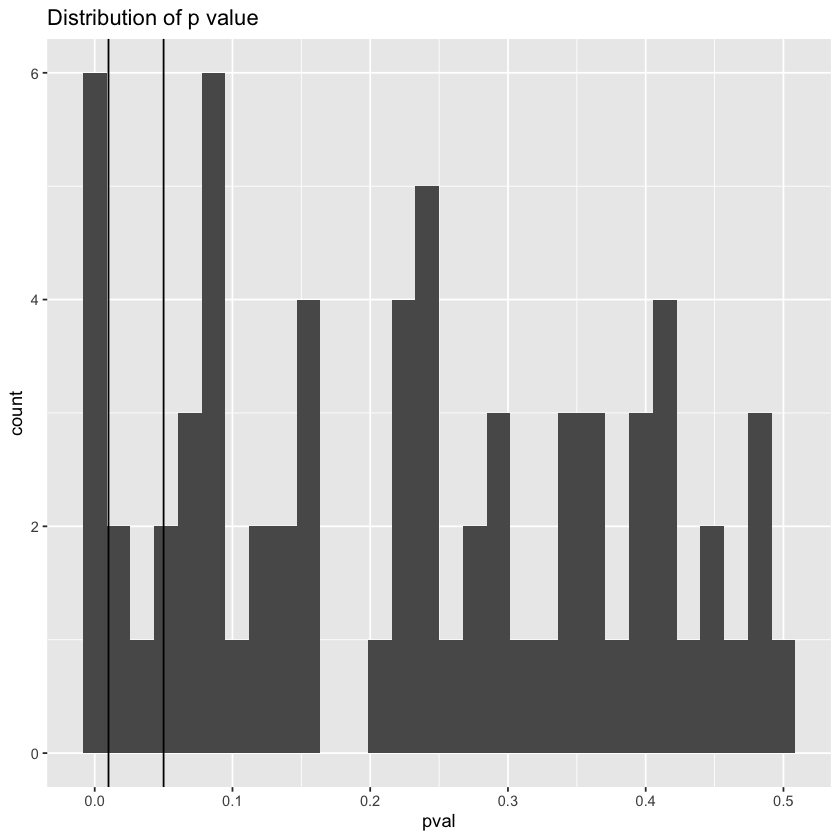

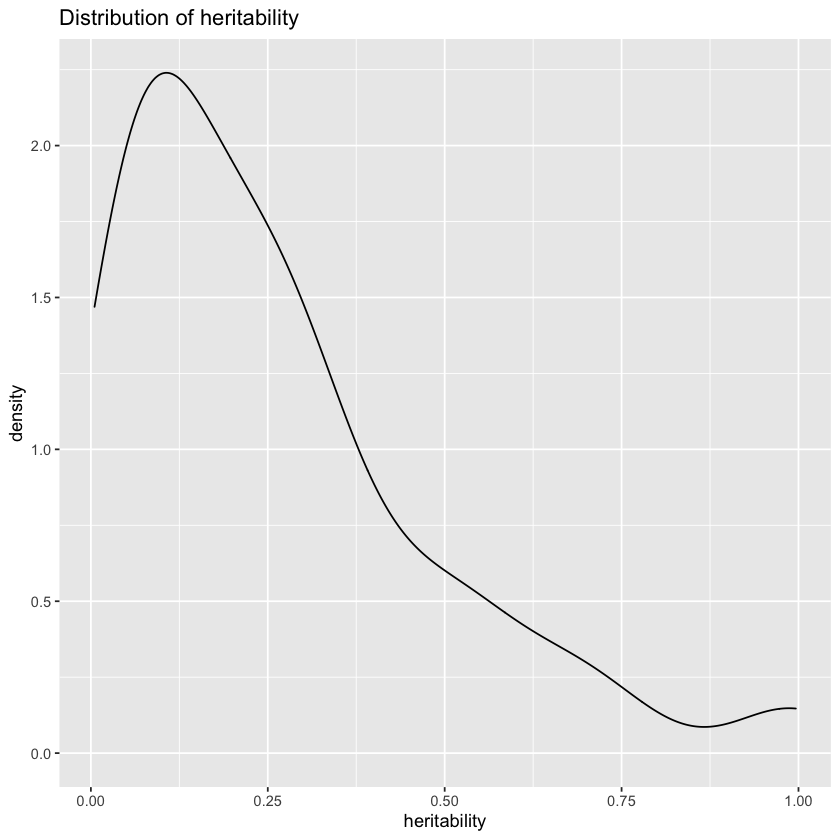

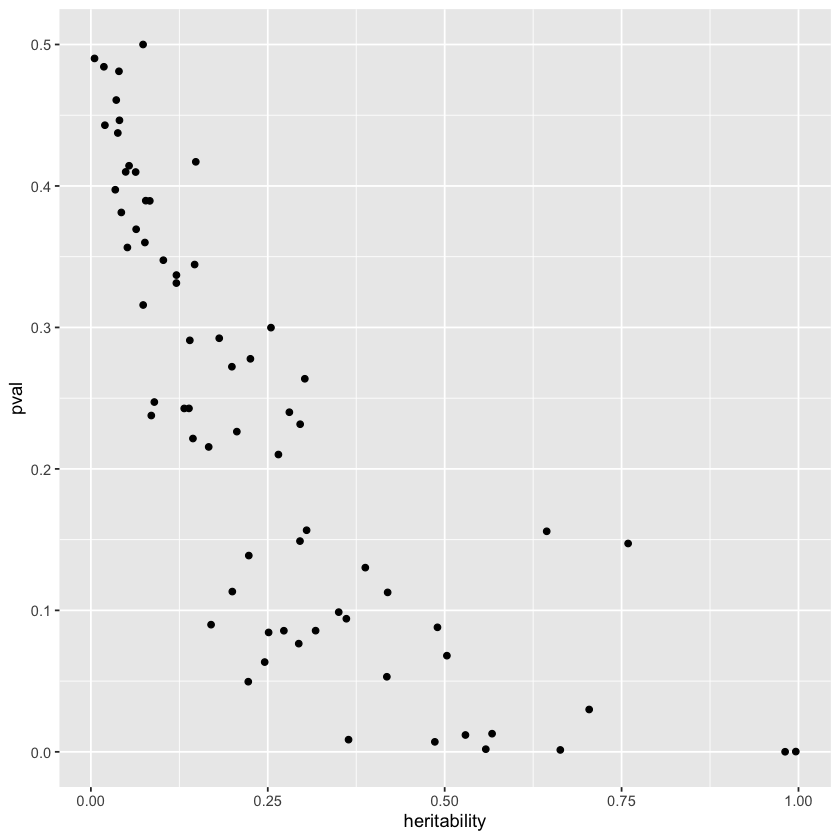

In [49]:
hsq = PCC_hsq%>%filter(heritability >= 0, heritability <= 1)
summ = tibble(
  data = c("heritability", "h_SE", "pval"),
  mean = c(
    hsq%>%pull(heritability)%>%mean(),
    hsq%>%pull(h_SE)%>%mean(),
    hsq%>%pull(pval)%>%mean()
  ),
  median = c(
    hsq%>%pull(heritability)%>%median(),
    hsq%>%pull(h_SE)%>%median(),
    hsq%>%pull(pval)%>%median()
    ),
  var = c(
    hsq%>%pull(heritability)%>%var(),
    hsq%>%pull(h_SE)%>%var(),
    hsq%>%pull(pval)%>%var()
  ))
summ
hsq%>%ggplot(aes(x = pval))+geom_histogram()+geom_vline(xintercept = 0.05)+geom_vline(xintercept = 0.01)+ggtitle("Distribution of p value")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability))+geom_density()+ggtitle("Distribution of heritability")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability,y = pval))+geom_point()






In [1]:
library(dplyr)
library(tibble)
library(readr)
library(ggplot2)
library(purrr)
library(stringr)
library(tidyr)
library(RVenn)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘RVenn’ was built under R version 4.0.2”

Attaching package: ‘RVenn’


The following object is masked from ‘package:tidyr’:

    unite




In [20]:
invisible(lapply(paste0('package:', names(sessionInfo()$otherPkgs)), detach, character.only=TRUE, unload=TRUE))



#### Distribution of HSQ with SusieR
The Hsq and weights of each genes in each tissues were recomputed using SusieR. all the hsq results are organized into one tibble with the following code blocks: 

In [10]:
oldw <- getOption("warn")
options(warn = -1,message = FALSE)

dir = "/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/"
Proj = c("Alz_AC_SNP","Alz_AC_FULL","Alz_DLPFC_SNP","Alz_DLPFC_FULL_2","Alz_PCC_SNP","Alz_PCC_Full")

tmp = tibble(
  Proj_Name = Proj
)

sum_hsq = function(hsq){
  summ = tibble(
    data = c("heritability", "h_SE", "pval"),
    mean = c(
      hsq%>%pull(heritability)%>%mean(),
      hsq%>%pull(h_SE)%>%mean(),
      hsq%>%pull(pval)%>%mean()
    ),
    median = c(
      hsq%>%pull(heritability)%>%median(),
      hsq%>%pull(h_SE)%>%median(),
      hsq%>%pull(pval)%>%median()
    ),
    var = c(
      hsq%>%pull(heritability)%>%var(),
      hsq%>%pull(h_SE)%>%var(),
      hsq%>%pull(pval)%>%var()
    ))
  
  return(summ)
}


analysis = tmp%>%mutate(
  hsq_data = map(Proj_Name,~read_delim(paste(dir,.x,"/WEIGHTS/all_hsq.txt",sep = ""),delim = " ")%>%filter(heritability >= 0, heritability <= 1)%>%mutate(region = str_replace(filename,".*\\.", ""))),
  hsq_rw_data = map(Proj_Name,~read_delim(paste(dir,.x,"/WEIGHTS/all_hsq.txt",sep = ""),delim = " ")%>%mutate(region = str_replace(filename,".*\\.", ""))),
  sum_hsq = map(hsq_data,~sum_hsq(.x)),
  hsq_dist = map(hsq_data,~filter(.x,heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability))+geom_density()+ggtitle("Distribution of heritability")),
  pval_dist = map(hsq_data,~(.x%>%ggplot(aes(x = pval))+geom_histogram()+geom_vline(xintercept = 0.05)+geom_vline(xintercept = 0.01)+ggtitle("Distribution of p value"))),
  pval_point = map(hsq_data,~(.x%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability,y = pval))+geom_point()+ggtitle("Scatter point of p value"))),
  result_data = map(Proj_Name,~read_delim(paste(dir,.x,"/result/all_result.txt",sep = ""),delim = "\t")%>%filter(FILE!="FILE")),
  result_data_TWAS = map(result_data,~.x%>%filter(!is.na(BEST.GWAS.ID))),
  result_model_count = map(result_data,~.x%>%group_by(MODEL)%>%count()),
)%>%mutate(
  result_model_dist = map(result_model_count,~.x%>%ggplot(aes(x = MODEL, y=n ))+geom_col()+ggtitle("distribution of models"))
)%>%suppressWarnings()

analysis_susie = analysis%>%mutate(
  hsq_susie_data = map(Proj_Name,~read_delim(paste(dir,.x,"/susie/all_hsq.txt",sep = ""),delim = "\t")%>%select(-file))
)%>%mutate(
  hsq_susie_dist = map(hsq_susie_data,~.x%>%ggplot(aes(x = hsq_full_sample))+geom_boxplot()+ggtitle("Distribution of heritability")))%>%suppressWarnings()

analysis_susie_ftr = analysis_susie%>%mutate(hsq_susie_data_ftr = map(hsq_susie_data,~.x%>%filter(CS_size > 0)))
analysis_join = full_join(
analysis_susie_ftr%>%select(Proj_Name,hsq_rw_data)%>%unnest()%>%select(-filename),
analysis_susie_ftr%>%select(Proj_Name,hsq_susie_data)%>%unnest())
acting = analysis_join%>%select(Proj_Name,heritability,pval,region,CS_size,hsq_full_sample,hsq_naive)
t_fusion = acting%>%filter(heritability> 0,heritability < 1,pval < 0.01)%>%ungroup()%>%group_by(region,Proj_Name)%>%select(hsq_fusion = heritability,hsq_susie = hsq_full_sample,hsq_naive )%>%pivot_longer(cols =hsq_fusion:hsq_naive,names_to = "hsq_type", values_to = "hsq" )
t_susie = acting%>%filter(CS_size > 0 )%>%ungroup()%>%group_by(region,Proj_Name)%>%select(hsq_fusion = heritability,hsq_susie = hsq_full_sample,hsq_naive )%>%pivot_longer(cols =hsq_fusion:hsq_naive,names_to = "hsq_type", values_to = "hsq" )
Alz_gene = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/Alz_gene_list.txt",delim = "\t")

## Acquir the TWAS result
analysis_sc_result = analysis%>%dplyr::select(Proj_Name,result_data_TWAS)%>%unnest()%>%group_by(Proj_Name)
Top_TWAS_gene = analysis_sc_result%>%arrange(TWAS.P)%>%dplyr::select(ID,CHR,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,EQTL.Z,EQTL.GWAS.Z,TWAS.Z,TWAS.P)
Top_TWAS_gene = Top_TWAS_gene%>%mutate(logTWAS.P = -log10(as.numeric(TWAS.P)))
Top_TWAS_gene = inner_join(x = Top_TWAS_gene, y = Alz_gene, by = c("ID" = "ensembl_id") )

options(warn = oldw)


Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)

Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)

Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)

Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)

Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)

Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_SE = col_double(),
  pval = col_double()
)

Parsed with column specification:
cols(
  filename = col_character(),
  heritability = col_double(),
  h_S

There are four filtering after heritability was estimated by REML of GCTA in the fusion workflow:

    Convergence: GCTA need to converge
    
    Positivity: Estimated hsq > 0 and < 1
    
    Significance: Pvalue of Estimated hsq < 0.01

The number of genes after each steps are as followed:
To put things in percepective, an addtional column CS indicating the amount of gene with at least one CS given by susieR.

In [7]:
analysis_susie%>%mutate(starting_gene = map_dbl(hsq_susie_data,~nrow(.x)), 
                        Convergence =  map_dbl(hsq_rw_data,~nrow(.x)),
                        Positivity =  map_dbl(hsq_data,~nrow(.x)),
                        Significance = map_dbl(result_data,~nrow(.x)),
                        CS = map_dbl(hsq_susie_data,~.x%>%filter(CS_size > 0)%>%nrow())
                        )%>%select(Proj_Name,starting_gene,Convergence,Positivity,Significance,CS)

Proj_Name,starting_gene,Convergence,Positivity,Significance,CS
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alz_AC_SNP,162,150,125,51,57
Alz_AC_FULL,162,154,127,54,55
Alz_DLPFC_SNP,162,148,129,41,56
Alz_DLPFC_FULL_2,162,78,54,29,55
Alz_PCC_SNP,160,147,106,43,38
Alz_PCC_Full,160,152,112,46,38


#### The distribution of average Hsq:
The mean of Hsq among the genes that passed the significance treshold is sysmetically a little bit higher than the Hsq compute by Susie in the tissues of  AC and DLPFC, but not the PCC. The variance of hsq estimated by susie is on par with that of the fusion.

In [8]:
# Sum stat for susie 
analysis_susie_sum = analysis_susie%>%unnest(cols = hsq_susie_data )%>%filter(CS_size > 0)%>%unnest(c(sum_hsq))%>%filter(data == "heritability")%>%group_by(Proj_Name)%>%summarise(Qt_hsq_susie = quantile(hsq_full_sample)%>%round( digits = 3)%>%paste(collapse = ","), n_hsq_susie = n(),mean_hsq_susie = mean(hsq_full_sample),var_hsq_susie =  var(hsq_full_sample),mean_hsq_naive = mean(hsq_naive))
# Sum stat for fusion
analysis_fusion_sum = analysis_susie%>%unnest(cols = hsq_data )%>%filter(pval < 0.01)%>%group_by(Proj_Name)%>%summarise(n_hsq = n(),mean_hsq = mean(heritability ),Qt_hsq = quantile(heritability )%>%round( digits = 3)%>%paste(collapse = ","),var_hsq = var(heritability ))
# Merge the two dataset
inner_join(analysis_susie_sum,analysis_fusion_sum)%>%select(Proj_Name,n_hsq_susie,n_hsq,mean_hsq_susie,mean_hsq,mean_hsq_naive,Qt_hsq_susie,Qt_hsq,var_hsq_susie,var_hsq)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "Proj_Name"



Proj_Name,n_hsq_susie,n_hsq,mean_hsq_susie,mean_hsq,mean_hsq_naive,Qt_hsq_susie,Qt_hsq,var_hsq_susie,var_hsq
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Alz_AC_FULL,55,54,0.1507397,0.1622208,0.1303161,"0.019,0.045,0.097,0.215,0.766","0.021,0.053,0.104,0.229,0.66",0.02467171,0.02344888
Alz_AC_SNP,57,51,0.1399740,0.1595784,0.1236560,"0.02,0.045,0.091,0.17,0.752","0.038,0.058,0.099,0.216,0.625",0.02271515,0.02167711
Alz_DLPFC_FULL_2,55,29,0.1299464,0.1560646,0.1152291,"0.019,0.034,0.064,0.16,0.788","0.017,0.066,0.119,0.172,0.558",0.02515941,0.01934301
Alz_DLPFC_SNP,56,50,0.1225468,0.1436298,0.1115788,"0.018,0.033,0.062,0.162,0.775","0.016,0.046,0.085,0.191,0.756",0.02257364,0.02546813
Alz_PCC_Full,38,46,0.1578710,0.1533610,0.1456015,"0.039,0.077,0.099,0.153,0.734","0.034,0.064,0.104,0.178,0.766",0.02813914,0.02289217
Alz_PCC_SNP,38,43,0.1550482,0.1524417,0.1434427,"0.04,0.073,0.101,0.151,0.736","0.034,0.06,0.104,0.18,0.684",0.02631249,0.02180619


#### Significant genes in each tissues's SNP data
The genes with a significant Fusion Hsq is not completly identicle with the genes that have a susie CS. As shown below. ~15 genes have only significant 

In [9]:
Venn(list(susie = t_susie%>%pull(region)%>%unique(), fusion = t_fusion%>%pull(region)%>%unique()))%>%ggvenn()

ERROR: Error in library.dynam(lib, package, package.lib): shared object ‘polyclip.dylib’ not found


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



An object of class "Venn"
Slot "sets":
$Set_1
[1] 1

$Set_2
[1] 2

$Set_3
[1] 3

$Set_4
[1] 4


Slot "names":
[1] "Set_1" "Set_2" "Set_3" "Set_4"


ERROR: Error: package or namespace load failed for ‘polyclip’ in library.dynam(lib, package, package.lib):
 shared object ‘polyclip.dylib’ not found


#### Overlap of credible sets
For each genes, each credible sets stands for the possible candidates of one of the SNVs that are responsible for the expression of the genes. To justify multivariate analysis, one should observed that the CS in each tissues shall not be be partially overlaped. Because a complete overlap stands for no difference across tissues while a none overlap stands for there is no similartiy among the tissues. Additional information can only be obtained by the partially overlap scenarios. 

Because each cs enssentially only indicating the potential candidates for one eQTL, pooling all the candidates together to form a CS inidicating all the possibile candidates for eQTL of particular genes shall be a valid operation. Therefore, All the SNVs in the CS of each tissues are pooled together.

Using the genes that have credible set for at least two tissues, the SNPs that are shared by all the tissues with availble tissues are shown as followed.

In [23]:
# This code block is what allowed the construction of the targeted data object
## susie filter by cs
Alz_gene = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/Alz_gene_list.txt",delim = "\t")
a = attach("/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/cs.RData")
working = a$b%>%select(-path)
working = working%>%mutate(cs_po = map(cs,~unlist(.x)),
                           cs_name = map2(.x = env,.y = cs_po,~(.x$fitted1$lbf_variable%>%colnames())[.y])
                          )
gene_2cs = working%>%group_by(region)%>%count()%>%filter(n==2)%>%pull(region)
gene_3cs = working%>%group_by(region)%>%count()%>%filter(n==3)%>%pull(region)
temp = working%>%select(region,cs_po,cs,cs_name,Proj_Name,hsq_susie)%>%pivot_wider(names_prefix = "cs_",names_from = Proj_Name,values_from = c(hsq_susie,cs_po,cs_name,cs))
temp = temp%>%filter(region%in%c(gene_2cs,gene_3cs))
Venn_tbl = temp%>%mutate(Venn_cs = pmap(list(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_PCC_SNP, cs_name_cs_Alz_DLPFC_SNP),function(first, second, third)(list(AC = first,PCC = second,DLPFC = third)%>%Venn())))
Venn_tbl  = Venn_tbl%>%mutate( 
  overlap = map(Venn_cs,~.x%>%overlap),
  perc_overlap = pmap_dbl(list(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_PCC_SNP, cs_name_cs_Alz_DLPFC_SNP,overlap),function(first, second, third,forth)(length(forth)/length(c(first, second, third)%>%unlist()%>%unique()))),
#  Venn_diagram = map(Venn_cs,~.x%>%ggvenn),
  cs_name_cs_Alz_AC_SNP = cs_name_cs_Alz_AC_SNP%>%map(~.x%>%paste(collapse=",")),
  cs_name_cs_Alz_PCC_SNP = cs_name_cs_Alz_PCC_SNP%>%map(~.x%>%paste(collapse=",")),
  cs_name_cs_Alz_DLPFC_SNP = cs_name_cs_Alz_DLPFC_SNP%>%map(~.x%>%paste(collapse=",")))%>%unnest(cols = c(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_PCC_SNP, cs_name_cs_Alz_DLPFC_SNP))
Venn_tbl = Venn_tbl%>%mutate(
  overl_c = map(overlap,~.x%>%paste(collapse=","))
)%>%unnest(overl_c)
Top_TWAS_gene_rf = Top_TWAS_gene%>%select(ID,gene,chr,logTWAS.P)%>%filter(str_detect(Proj_Name,"SNP"))%>%arrange(-logTWAS.P)%>%pivot_wider(names_prefix = "logTWAS.P_",names_from = Proj_Name,values_from = logTWAS.P)
result = inner_join(Top_TWAS_gene_rf,Venn_tbl,by = c("ID" ="region"))%>%arrange(-perc_overlap)%>%select(ID:cs_name_cs_Alz_PCC_SNP,overl_c,perc_overlap)%>%mutate(Three_tissues = ID%in%gene_3cs)

Parsed with column specification:
cols(
  gene = col_character(),
  ensembl_id = col_character(),
  chr = col_double()
)

The following object is masked from file:/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/cs.RData (pos = 3):

    b


Adding missing grouping variables: `Proj_Name`



In [37]:
## Showing the result
length(gene_3cs)
length(gene_2cs)
colnames(result)
result%>%select(ID,gene,'logTWAS.P_Alz_DLPFC_SNP','logTWAS.P_Alz_PCC_SNP','logTWAS.P_Alz_AC_SNP',Three_tissues,perc_overlap)%>%arrange(-perc_overlap)


[1] 32

[1] 11

[1] "ID"                         "gene"                      
 [3] "chr"                        "logTWAS.P_Alz_DLPFC_SNP"   
 [5] "logTWAS.P_Alz_PCC_SNP"      "logTWAS.P_Alz_AC_SNP"      
 [7] "hsq_susie_cs_Alz_AC_SNP"    "hsq_susie_cs_Alz_DLPFC_SNP"
 [9] "hsq_susie_cs_Alz_PCC_SNP"   "cs_po_cs_Alz_AC_SNP"       
[11] "cs_po_cs_Alz_DLPFC_SNP"     "cs_po_cs_Alz_PCC_SNP"      
[13] "cs_name_cs_Alz_AC_SNP"      "cs_name_cs_Alz_DLPFC_SNP"  
[15] "cs_name_cs_Alz_PCC_SNP"     "overl_c"                   
[17] "perc_overlap"               "Three_tissues"

ID,gene,logTWAS.P_Alz_DLPFC_SNP,logTWAS.P_Alz_PCC_SNP,logTWAS.P_Alz_AC_SNP,Three_tissues,perc_overlap
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
ENSG00000161929,SCIMP,3.62160210,0.838631998,0.81211282,FALSE,1.00000000
ENSG00000099817,POLR2E,3.52143350,3.521433504,2.86012091,TRUE,1.00000000
ENSG00000007047,MARK4,3.01863449,NA,NA,TRUE,1.00000000
ENSG00000180448,HMHA1,1.85078089,0.906578315,NA,TRUE,1.00000000
ENSG00000264538,SUZ12P1,0.43062609,0.651695137,0.51533010,TRUE,1.00000000
ENSG00000073008,PVR,11.05998184,13.436518915,15.54515514,TRUE,0.85714286
ENSG00000214309,MBLAC1,NA,0.774690718,NA,TRUE,0.85000000
ENSG00000140416,TPM1,1.51855737,NA,1.29217443,FALSE,0.83333333
ENSG00000121716,PILRB,NA,0.442492798,NA,TRUE,0.77777778


In [25]:
#### To looks at the overlap between each genes of interest
gene_ID = "ENSG00000161929"
result%>%filter(ID %in%  gene_ID)%>%select(cs_name_cs_Alz_AC_SNP,cs_name_cs_Alz_DLPFC_SNP,cs_name_cs_Alz_PCC_SNP,overl_c)%>%t()


cs_name_cs_Alz_AC_SNP,"17:5124877_C_T,17:5125249_A_G,17:5125333_A_T,17:5126207_A_G,17:5126224_G_T,17:5126674_A_G,17:5128482_A_G,17:5133734_C_T,17:5133807_A_G,17:5134814_A_G"
cs_name_cs_Alz_DLPFC_SNP,
cs_name_cs_Alz_PCC_SNP,"17:5124877_C_T,17:5125249_A_G,17:5125333_A_T,17:5126207_A_G,17:5126224_G_T,17:5126674_A_G,17:5128482_A_G,17:5133734_C_T,17:5133807_A_G,17:5134814_A_G"
overl_c,"17:5124877_C_T,17:5125249_A_G,17:5125333_A_T,17:5126207_A_G,17:5126224_G_T,17:5126674_A_G,17:5128482_A_G,17:5133734_C_T,17:5133807_A_G,17:5134814_A_G"


#### Visualization of targeted genes
Since both ggvenn and susie R are not availble in jupyterLab, the following visualization are done in RStudio


In [ ]:
Venn_diag  = Venn_tbl%>%filter(region %in%  gene_ID)%>%mutate(Venn_diagram = map(Venn_cs,~.x%>%ggvenn))
working%>%filter(region %in%  gene_ID)%>%mutate(susie_plot = map(env,~.x$fitted1%>%susie_plot(y = "PIP",b = b)))
Venn_diag$Venn_diagram

#### Distribution of number of overlaped CS in each tissues
It turn out that most of the genes have only one overlapped CS, the only one with 2 CS is 

In [26]:
anchor = function(list,number){
  l = integer()
  for (i in list ){
    l = c(l, (sum(i%>%unlist() %in% number)>0))
  }
  return(list[l])
}

Venn_tbl_SNP = Venn_tbl%>%select(region,overlap)
Working = inner_join(working,Venn_tbl_SNP)
Working = Working%>%mutate(ovl_pos = map2(.x = env,.y = overlap,~which(.x$fitted1$mu%>%colnames() %in% .y) ))
cs_overl = Working%>%mutate(ovl_cs = map2(cs,ovl_pos,~anchor(.x,.y)),
                 n_ovl_cs = map_dbl(ovl_cs, ~length(.x)),
                p_ovl_cs  = n_ovl_cs/CS_size)
cs_overl%>%group_by(Proj_Name,n_ovl_cs)%>%summarise(n())
cs_overl%>%group_by(Proj_Name,CS_size)%>%summarise(n())

Joining, by = "region"

`summarise()` regrouping output by 'Proj_Name' (override with `.groups` argument)



Proj_Name,n_ovl_cs,n()
<chr>,<dbl>,<int>
Alz_AC_SNP,0,7
Alz_AC_SNP,1,32
Alz_AC_SNP,2,1
Alz_DLPFC_SNP,0,7
Alz_DLPFC_SNP,1,32
Alz_DLPFC_SNP,2,1
Alz_PCC_SNP,0,6
Alz_PCC_SNP,1,31
Alz_PCC_SNP,2,1


`summarise()` regrouping output by 'Proj_Name' (override with `.groups` argument)



Proj_Name,CS_size,n()
<chr>,<dbl>,<int>
Alz_AC_SNP,1,31
Alz_AC_SNP,2,6
Alz_AC_SNP,4,2
Alz_AC_SNP,5,1
Alz_DLPFC_SNP,1,29
Alz_DLPFC_SNP,2,7
Alz_DLPFC_SNP,3,2
Alz_DLPFC_SNP,4,1
Alz_DLPFC_SNP,7,1


In [27]:
(cs_overl%>%filter(n_ovl_cs == 2)%>%pull(region))[1]

[1] "ENSG00000196126"

In [35]:
result%>%filter(ID == "ENSG00000196126")%>%select(ID:hsq_susie_cs_Alz_PCC_SNP,'perc_overlap','Three_tissues')
colnames(result)

ID,gene,chr,logTWAS.P_Alz_DLPFC_SNP,logTWAS.P_Alz_PCC_SNP,logTWAS.P_Alz_AC_SNP,hsq_susie_cs_Alz_AC_SNP,hsq_susie_cs_Alz_DLPFC_SNP,hsq_susie_cs_Alz_PCC_SNP,perc_overlap,Three_tissues
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
ENSG00000196126,HLA-DRB1,6,3.277366,4.806875,2.732828,0.5356601,0.5554409,0.5969172,0.4434783,TRUE


[1] "ID"                         "gene"                      
 [3] "chr"                        "logTWAS.P_Alz_DLPFC_SNP"   
 [5] "logTWAS.P_Alz_PCC_SNP"      "logTWAS.P_Alz_AC_SNP"      
 [7] "hsq_susie_cs_Alz_AC_SNP"    "hsq_susie_cs_Alz_DLPFC_SNP"
 [9] "hsq_susie_cs_Alz_PCC_SNP"   "cs_po_cs_Alz_AC_SNP"       
[11] "cs_po_cs_Alz_DLPFC_SNP"     "cs_po_cs_Alz_PCC_SNP"      
[13] "cs_name_cs_Alz_AC_SNP"      "cs_name_cs_Alz_DLPFC_SNP"  
[15] "cs_name_cs_Alz_PCC_SNP"     "overl_c"                   
[17] "perc_overlap"               "Three_tissues"

## MV Susie


## Association testing result
The association with the TWAS was produced using the following code.For the DLPFC, there are 22 skipped genes out of the 30 genes. Making a total of 8 genes with TWAS Z score.

For the PCC, there are 5 skipped gene out of six genes.

The error produced for the skipped genes is along the line of
>had 42 / 78 non-overlapping GWAS Z-scores, skipping this gene.

which stand for the fraction of snp in the WGS but not have a sums stat is larger than the  maximum fraction of SNPs allowed to be missing per gene (will be imputed using LD).


TODO：more in depth analysis, including both the strategy for future analysis.


In [1]:
a = tibble(a = 1 , b = 2)
read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/DLPFC/all_hsq.txt")



NameError: name 'tibble' is not defined

In [ ]:
# Supplementary
This section contains analysis that may provide insights.



In [ ]:
# To see what happened in the window of 500000
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_5E6/ \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  -J 10 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

In [ ]:
# To see what happened in the hsq cut off of 0.05
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_005_correct \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 10000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --asso_mem "60G" \
  --job_size 1\
  --hsq_p 0.05 \
  -J 10 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz \
  --genotype_list /home/hs3163/fake_Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/Alz_passed_gene_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 500000 \
  --container /home/hs3163/system_file/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --asso_mem "60G" \
  --job_size 1\
  --weights_list /home/hs3163/fake_weight_list.txt \
  -J 6 -q csg -c ~/GIT/neuro-twas/template/csg.yml -s build &

In [ ]:
library(dplyr)
library(plink2R)


wgt_list = read.table("/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/Alz_PCC_SNP/WEIGHTS/geneTpmResidualsAgeGenderAdj_rename.weights_list.txt",header = T)
wgt_list$WGT
chr = unique(wgt_list$CHR)
N = nrow(wgt_list)


wgt.file = paste(wgt_list$WGT[wgt_list$CHR == 7])
wgt.file ="/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/Alz_PCC_SNP/WEIGHTS/geneTpmResidualsAgeGenderAdj_rename.ENSG00000085514.wgt.RDat"
wgt_info = attach(wgt.file)

wgt_info$wgt.matrix[,]
wgt_info$wgt.matrix[,wgt_info$mod.best

row.pval = grep( "pval" , rownames(wgt_info$cv.performance) )
mod.best = which.min(apply(wgt_info$cv.performance[row.pval,,drop=F],2,min,na.rm=T))
cur.twasr2pred = wgt.matrix[,mod.best] %*% cur.LD %*% wgt.matrix[,mod.best]



wgt_info$wgt.matrix[,mod.best]


genos = read_plink("",impute="avg")
?read_plink
cur.LD = t(cur.genos) %*% cur.genos / (nrow(cur.genos)-1)


wgt_info


In [ ]:
## MV Susie
nohup sos run ~/GIT/neuro-twas/Workflow/mv_susie.ipynb mv_susie  \
  --molecular_pheno_dir "/home/hs3163/Project/Alz/multi/molecular_phenotype_list" \
  --region_list "/home/hs3163/Project/Alz/multi/mv_susie_gene_list.txt" \
  --wd "/home/hs3163/Project/Alz/multi" \
  --name_prefix "geneTpmResidualsAgeGenderAdj_rename" \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --job_size 1\
  -J 6 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml &

sos dryrun ~/GIT/neuro-twas/Workflow/mv_susie.ipynb mv_susie  \
  --molecular_pheno_dir "/home/hs3163/Project/Alz/multi/molecular_phenotype_list" \
  --region_list "/home/hs3163/Project/Alz/multi/mv_susie_gene_list.txt" \
  --wd "/home/hs3163/Project/Alz/multi" \
  --name_prefix "geneTpmResidualsAgeGenderAdj_rename" \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --job_size 1


# Citation
    1.Jansen IE, Savage JE, Watanabe K, Bryois J, Williams DM, Steinberg S, Sealock J, Karlsson IK, Hägg S, Athanasiu L, Voyle N, Proitsi P, Witoelar A, Stringer S, Aarsland D, Almdahl IS, Andersen F, Bergh S, Bettella F, Bjornsson S, Brækhus A, Bråthen G, de Leeuw C, Desikan RS, Djurovic S, Dumitrescu L, Fladby T, Hohman TJ, Jonsson PV, Kiddle SJ, Rongve A, Saltvedt I, Sando SB, Selbæk G, Shoai M, Skene NG, Snaedal J, Stordal E, Ulstein ID, Wang Y, White LR, Hardy J, Hjerling-Leffler J, Sullivan PF, van der Flier WM, Dobson R, Davis LK, Stefansson H, Stefansson K, Pedersen NL, Ripke S, Andreassen OA, Posthuma D. Genome-wide meta-analysis identifies new loci and functional pathways influencing Alzheimer’s disease risk  Nature Genetics, 2019 Mar;51(3):404-413. doi: 10.1038/s41588-018-0311-9

Loading required package: Rcpp

Loading required package: RcppEigen

